# Test with CodeComplex Dataset


**AIM**: Load our models (linear classifier, LSTM, custom Transformer and fine-tuned codeBERT) and evaluate their performance on the codeComplex dataset.

## Extract the CodeComplex dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

path = 'TESTING'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/TESTING'

In [ ]:
!pip install datasets
import json
import random

In [ ]:
import torch

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
import json

file_data = "python_data.jsonl"

data = []

with open(file_data, "r") as f:
    for line in f:
        data.append(json.loads(line))

print(f"Number of elements {len(data)}")

Number of elements 4900


In [ ]:
print(data[0])

{'src': "from math import sqrt\n\na, v = map(int, input().split())\nl, d, w = map(int, input().split())\n\ndef findt(u, v, a, dist):\n\tfront = (v*v-u*u)/(2*a)\n\tif front > dist:\n\t\treturn (sqrt(u*u+2*a*dist)-u)/a\n\treturn (v-u)/a + (dist-front)/v\n\ndef solve(a, v, l, d, w):\n\tif v <= w or 2*a*d <= w*w:\n\t\treturn findt(0, v, a, l)\n\tafter = findt(w, v, a, l-d)\n\tpeak = sqrt(a*d + w*w/2)\n\tif peak > v:\n\t\ttravel = (v*v-w*w/2)/a\n\t\tbefore = (2*v-w)/a + (d-travel)/v\n\telse:\n\t\tbefore = (2*peak-w)/a\n\treturn before + after\n\nprint(f'{solve(a, v, l, d, w):.8f}')", 'complexity': 'constant', 'problem': '0005_D', 'from': 'CODEFORCES', 'tags': 'implementation,math'}


In [ ]:
final_dataset = []

with open(file_data, "r") as f:
    for line in f:
        data = json.loads(line)

        if "src" in data and "complexity" in data:
            entry = {
                "solution_code": data["src"],
                "time_complexity": data["complexity"]
            }
            final_dataset.append(entry)

print(f"Total entry created: {len(final_dataset)}")

Total entry created: 4900


In [ ]:
compatible_classes = {"constant", "linear", "logn", "nlogn", "quadratic"}

In [ ]:
final_dataset = [
    entry for entry in final_dataset
    if entry["time_complexity"] in compatible_classes
]

print(f"Filtered Dataset with elements: {len(final_dataset)}")

Filtered Dataset with elements: 3766


In [ ]:
class_mapping = {
    "constant": "O(1)",
    "linear": "O(n)",
    "logn": "O(logn)",
    "nlogn": "O(nlogn)",
    "quadratic": "O(n**2)"
}

In [ ]:
final_dataset = [
    {
        "solution_code": entry["solution_code"],
        "time_complexity": class_mapping[entry["time_complexity"]]
    }
    for entry in final_dataset
    if entry["time_complexity"] in class_mapping
]

In [ ]:
set_complexity = set(entry["time_complexity"] for entry in final_dataset)

print("Complexity classes present in the dataset:")
for cls in sorted(set_complexity):
    print(f"  - {cls}")

Complexity classes present in the dataset:
  - O(1)
  - O(logn)
  - O(n)
  - O(n**2)
  - O(nlogn)


### Clean and Normalize code

In [ ]:
!pip install black
!pip install astor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:00


In [ ]:
import black
import logging
import re

logger = logging.getLogger(__name__)

singlequote_str_pattern = r"\".*?\""
double_quote_str_pattern = r"\'.*?\'"
singlequote_docstring_pattern = r"^\s*'{3,}[\s\S]*?'{3,}"
doublequote_docstring_pattern = r"^\s*\"{3,}[\s\S]*?\"{3,}"
singleline_comment_pattern = r"#[^\r\n]*$"

# Remove all docstrings
docstrings_regex = "(" \
+ "|".join([r"\n?" + singlequote_docstring_pattern,
            r"\n?" + doublequote_docstring_pattern]) \
+ ")"
def remove_docstrings(code):
  return re.sub(docstrings_regex, "", code, flags=re.MULTILINE)

# Remove single line comments outside of strings literals ("#', '#', """#""", '''#''')
pattern = "(" \
+ "|".join([singlequote_str_pattern,
            double_quote_str_pattern,
            singlequote_docstring_pattern,
            doublequote_docstring_pattern]) \
+ ")|(" \
+ r"\n?" + singleline_comment_pattern \
+ ")"
def replacer(match):
  # Remove group 2 if no group 1 match
  if match.group(2) is not None:
    return ""
  else:
    return match.group(1)
def remove_singleline_comments(code):
  return re.compile(pattern, re.MULTILINE).sub(replacer, code)

# Final function to clean the code
def clean_code(input_code: str) -> str:
  # Remove docstrings
  code = remove_docstrings(input_code)

  # Remove single line comments
  code = remove_singleline_comments(code)

  # Remove __author__, __version__, etc.
  code = re.sub(r"^__\w+__\s*=.*\n", "", code, flags=re.MULTILINE)

  # Format code so that it is PEP 8 compliant https://peps.python.org/pep-0008/
  # => standardize indentation (4 spaces per level), remove extra white spaces...
  try:
    code = black.format_str(code, mode=black.FileMode())
  except Exception as e:
    logger.warning(f"Code cleaning failed: {str(e)}. Skipping code formatting.")
    return

  return code

In [ ]:
import ast
import astor

class CodeBlockTagger(ast.NodeVisitor):
    def __init__(self):
        self.blocks = {
            "imports": [],
            "functions": [],
            "global": []
        }

    def visit_Module(self, node):
        global_block = []

        for stmt in node.body:
            if isinstance(stmt, (ast.Import, ast.ImportFrom)):
                try:
                    self.blocks["imports"].append(astor.to_source(stmt).strip())
                except Exception:
                    continue
            elif isinstance(stmt, ast.FunctionDef):
                self.blocks["functions"].append(astor.to_source(stmt).strip())
            else:
                try:
                    code = astor.to_source(stmt).strip()
                    global_block.append(code)
                except Exception:
                    continue

        if global_block:
            self.blocks["global"].append("\n".join(global_block))


def tag_code_blocks(code: str) -> str:
    try:
        tree = ast.parse(code)
        tagger = CodeBlockTagger()
        tagger.visit(tree)

        parts = []

        if tagger.blocks["imports"]:
            parts.append("<IMPORTS_START>\n" + "\n".join(tagger.blocks["imports"]) + "\n<IMPORTS_END>")

        for func in tagger.blocks["functions"]:
            parts.append(f"<FUNC_DEF_START>\n{func}\n<FUNC_DEF_END>")

        for glob in tagger.blocks["global"]:
            parts.append(f"<GLOBAL_CODE_START>\n{glob}\n<GLOBAL_CODE_END>")

        return "\n\n".join(parts)

    except Exception as e:
        return f"⚠️ Parsing failed: {e}"

In [ ]:
import ast
import astor
import builtins
import sys

class CodeNormalizer(ast.NodeTransformer):
    def __init__(self):
        super().__init__()
        self.global_var_map = {}
        self.func_map = {}
        self.counter = {"var": 0, "func": 0}
        self.builtin_names = set(dir(builtins))
        self.standard_modules = set(sys.builtin_module_names)
        self.imported_names = set()
        self.extra_known_names = {'exit', 'quit', 'help', 'copyright', 'credits', 'license'}
        self.shadowed_names = set()
        self.local_var_map = None

    def _get_var_name(self, original):
        if (original in self.builtin_names or
            original in self.standard_modules or
            original in self.imported_names or
            original in self.extra_known_names) and original not in self.shadowed_names:
            return original

        if self.local_var_map is not None:
            if original in self.global_var_map:
                return self.global_var_map[original]
            if original not in self.local_var_map:
                new_name = f"var_{self.counter['var']}"
                self.counter['var'] += 1
                self.local_var_map[original] = new_name
            return self.local_var_map[original]
        else:
            if original not in self.global_var_map:
                self.global_var_map[original] = f"var_{self.counter['var']}"
                self.counter['var'] += 1
            return self.global_var_map[original]

    def _get_func_name(self, original):
        if (original in self.builtin_names or
            original in self.standard_modules or
            original in self.imported_names or
            original in self.extra_known_names) and original not in self.shadowed_names:
            return original

        if original not in self.func_map:
            self.func_map[original] = f"func_{self.counter['func']}"
            self.counter['func'] += 1
        return self.func_map[original]

    def visit_Import(self, node):
        for alias in node.names:
            self.imported_names.add(alias.asname or alias.name)
        return node

    def visit_ImportFrom(self, node):
        for alias in node.names:
            self.imported_names.add(alias.asname or alias.name)
        return node

    def visit_FunctionDef(self, node):
        if node.name in self.builtin_names or node.name in self.extra_known_names:
            self.shadowed_names.add(node.name)
        node.name = self._get_func_name(node.name)
        for arg in node.args.args:
            if arg.arg not in self.global_var_map:
                self.global_var_map[arg.arg] = f"var_{self.counter['var']}"
                self.counter['var'] += 1

        old_local_map = self.local_var_map
        self.local_var_map = {}

        self.generic_visit(node)

        self.local_var_map = old_local_map
        return node

    def visit_arg(self, node):
        if node.arg not in self.global_var_map:
            self.global_var_map[node.arg] = f"var_{self.counter['var']}"
            self.counter['var'] += 1
        node.arg = self.global_var_map[node.arg]
        return node

    def visit_Name(self, node):
        parent = getattr(node, 'parent', None)

        if ((node.id in self.builtin_names or
             node.id in self.standard_modules or
             node.id in self.imported_names or
             node.id in self.extra_known_names)
            and node.id not in self.shadowed_names):
            return node

        if isinstance(parent, ast.Call) and parent.func == node:
            node.id = self._get_func_name(node.id)
        elif isinstance(node.ctx, (ast.Load, ast.Store, ast.Del)):
            node.id = self._get_var_name(node.id)
        return node

    def generic_visit(self, node):
        for child in ast.iter_child_nodes(node):
            child.parent = node
        return super().generic_visit(node)

def normalize_code(code: str) -> str:
    try:
        tree = ast.parse(code)
        normalizer = CodeNormalizer()
        tree = normalizer.visit(tree)
        ast.fix_missing_locations(tree)
        normalized_code = astor.to_source(tree)
        return normalized_code
    except Exception as e:
        print(f"⚠️ Parsing failed: {e}")
        return code

### Tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1

We add the special_tags on the tokenizer, so that the single tags is treated as a single token and to help the model to recognize the structure.

In [ ]:
my_special_tags = ['<IMPORTS_START>', '<IMPORTS_END>',
                   '<FUNC_DEF_START>', '<FUNC_DEF_END>',
                   '<GLOBAL_CODE_START>', '<GLOBAL_CODE_END>'
                    ]


special_tokens_dict = {'additional_special_tokens': my_special_tags}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Original Vocabulary: {tokenizer.vocab_size - num_added_toks}")
print(f"Added {num_added_toks} new tokens.")
print(f"New dimension of the tokenizer's vocabulary: {len(tokenizer)}")

Original Vocabulary: 50259
Added 6 new tokens.
New dimension of the tokenizer's vocabulary: 50272


--------------------------------------------------------------------------------

Filtering our dataset considering only the input codes with max 512 tokens.

In [ ]:
MAX_TOKENS = 512

final_dataset = [
    entry for entry in final_dataset
    if len(tokenizer.tokenize(entry['solution_code'])) <= MAX_TOKENS
]

print(f"Total number of example after filtering: {len(final_dataset)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (2257 > 512). Running this sequence through the model will result in indexing errors


Total number of example after filtering: 3113


In [ ]:
final_dataset_without_tags = [
    {**entry, "solution_code": normalize_code(clean_code(entry["solution_code"]))}
    for entry in final_dataset
]

final_dataset_with_tags = [
    {**entry, "solution_code": tag_code_blocks(normalize_code(clean_code(entry["solution_code"])))}
    for entry in final_dataset
]

final_dataset_without_tags_linear_LSTM = [
    {**entry, "solution_code": normalize_code(clean_code(entry["solution_code"]))}
    for entry in final_dataset
]

In [ ]:
print(f"Total couple after normalizing: {len(final_dataset_with_tags)}")
print(f"Total couple after normalizing: {len(final_dataset_without_tags)}")
print(f"Total couple after normalizing: {len(final_dataset_without_tags_linear_LSTM)}")

Total couple after normalizing: 3113
Total couple after normalizing: 3113
Total couple after normalizing: 3113


In [ ]:
print(final_dataset_with_tags[0]["solution_code"])
print(final_dataset_with_tags[0]['time_complexity'])
print(final_dataset_without_tags[0]["solution_code"])
print(final_dataset_without_tags[0]['time_complexity'])
print(final_dataset_without_tags_linear_LSTM[0]["solution_code"])
print(final_dataset_without_tags_linear_LSTM[0]['time_complexity'])

<IMPORTS_START>
from math import sqrt
<IMPORTS_END>

<FUNC_DEF_START>
def func_0(var_5, var_1, var_0, var_6):
    var_7 = (var_1 * var_1 - var_5 * var_5) / (2 * var_0)
    if var_7 > var_6:
        return (sqrt(var_5 * var_5 + 2 * var_0 * var_6) - var_5) / var_0
    return (var_1 - var_5) / var_0 + (var_6 - var_7) / var_1
<FUNC_DEF_END>

<FUNC_DEF_START>
def func_1(var_0, var_1, var_2, var_3, var_4):
    if var_1 <= var_4 or 2 * var_0 * var_3 <= var_4 * var_4:
        return func_0(0, var_1, var_0, var_2)
    var_8 = func_0(var_4, var_1, var_0, var_2 - var_3)
    var_9 = sqrt(var_0 * var_3 + var_4 * var_4 / 2)
    if var_9 > var_1:
        var_10 = (var_1 * var_1 - var_4 * var_4 / 2) / var_0
        var_11 = (2 * var_1 - var_4) / var_0 + (var_3 - var_10) / var_1
    else:
        var_11 = (2 * var_9 - var_4) / var_0
    return var_11 + var_8
<FUNC_DEF_END>

<GLOBAL_CODE_START>
var_0, var_1 = map(int, input().split())
var_2, var_3, var_4 = map(int, input().split())
print(f'{func_1(var_0

-------------------------------------------------------------------------

In [ ]:
classes = ['O(1)', 'O(logn)', 'O(n)', 'O(n**2)', 'O(n*m)', 'O(n+m)', 'O(nlogn)']

label2id = {label: idx for idx, label in enumerate(classes)}
id2label = {idx: label for label, idx in label2id.items()}

In [ ]:
print(label2id)

{'O(1)': 0, 'O(logn)': 1, 'O(n)': 2, 'O(n**2)': 3, 'O(n*m)': 4, 'O(n+m)': 5, 'O(nlogn)': 6}


Let's now convert each "time_complexity" into a numeric "label" field

In [ ]:
for example in final_dataset_with_tags:
    example['label'] = label2id[example['time_complexity']]

Creating The tokenized dataset

In [ ]:
from datasets import Dataset

dataset = Dataset.from_list(final_dataset_with_tags)


def tokenize_function(examples):
    tokenized = tokenizer(
        examples['solution_code'],
        padding='max_length',
        truncation=True,
        max_length=512,
        add_special_tokens=True
    )
    tokenized['label'] = examples['label']
    return tokenized

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3113 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['solution_code', 'time_complexity', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3113
})

## Import Models

Collate + dataLoader functions

In [ ]:
import torch
from torch.utils.data import DataLoader


def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    labels = torch.stack([torch.tensor(item['label']) for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_dataloader = DataLoader(tokenized_dataset, batch_size=64, shuffle=True,
                              collate_fn=collate_fn, num_workers=4, pin_memory=True)

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]  # broadcast over batch
        return x

class ComplexityClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, d_model=256, nhead=8, num_layers=4, max_len=512, dropout=0.4):
        super(ComplexityClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)                  # [B, L, D]
        x = self.pos_encoder(x)                        # [B, L, D]

        attn_mask = attention_mask == 0                # [B, L] boolean mask
        x = self.transformer_encoder(x, src_key_padding_mask=attn_mask)

        x = x[:, 0, :]     # [CLS] token embedding
        x = self.layer_norm(x)
        x = self.dropout(x)
        logits = self.classifier(x)                    # [B, num_labels]
        return logits

In [ ]:
vocab_size = tokenizer.get_vocab().__len__()

model = ComplexityClassifier(
    vocab_size=vocab_size,
    num_labels=len(label2id),
    d_model=256,
    nhead=8,
    num_layers=4
)

Load Custom Transformer

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ComplexityClassifier(
  (embedding): Embedding(50272, 256)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=256, out_features=7, bias=True)
)

Load CodeBERT

In [ ]:
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/TESTING")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

tokenizer_without_tags = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [ ]:
for example in final_dataset_without_tags:
    example['label'] = label2id[example['time_complexity']]

def tokenize_function_codeBERT(examples):
    tokenized = tokenizer_without_tags(
        examples['solution_code'],
        padding='max_length',
        truncation=True,
        max_length=512,
        add_special_tokens=True
    )
    tokenized['label'] = examples['label']
    return tokenized



dataset_without_tags = Dataset.from_list(final_dataset_without_tags)
tokenized_dataset_without_tags = dataset_without_tags.map(tokenize_function_codeBERT, batched=True)
train_dataloader_without_tags = DataLoader(tokenized_dataset_without_tags, batch_size=64, shuffle=True,
                              collate_fn=collate_fn, num_workers=4, pin_memory=True)

Map:   0%|          | 0/3113 [00:00<?, ? examples/s]

Load Linear Classifier and its vectorizer

In [ ]:
from joblib import load

classifier = load('logistic_regression.joblib')
vectorizer = load("vectorizer.joblib")

Load LSTM and its vectorizer

In [ ]:
!pip install tensorflow

In [ ]:
vectorizer_LSTM = load("vectorizer_LSTM.joblib")

import tensorflow as tf

model_LSTM = tf.keras.Sequential([
    vectorizer_LSTM,
    tf.keras.layers.Embedding(input_dim=vectorizer_LSTM.vocabulary_size(), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

dummy_input = tf.constant(["dummy input text"])
_ = model_LSTM(dummy_input)

Load LSTM weights

In [ ]:
model_LSTM.load_weights("lstm.weights.h5")

## Testing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
!pip install seaborn scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Evaluation of Linear Classifier

In [ ]:
# Prepare the dataset
codes = [item["solution_code"] for item in final_dataset_without_tags_linear_LSTM]
labels = [item["time_complexity"] for item in final_dataset_without_tags_linear_LSTM]

In [ ]:
# Imput Embedding with TF-IDF Features
X = vectorizer.transform(codes)

In [ ]:
# Evaluate the classifier
y_pred = classifier.predict(X)

class_names = ["O(1)", "O(logn)", "O(n)", "O(n**2)", "O(n*m)", "O(n+m)", "O(nlogn)"]

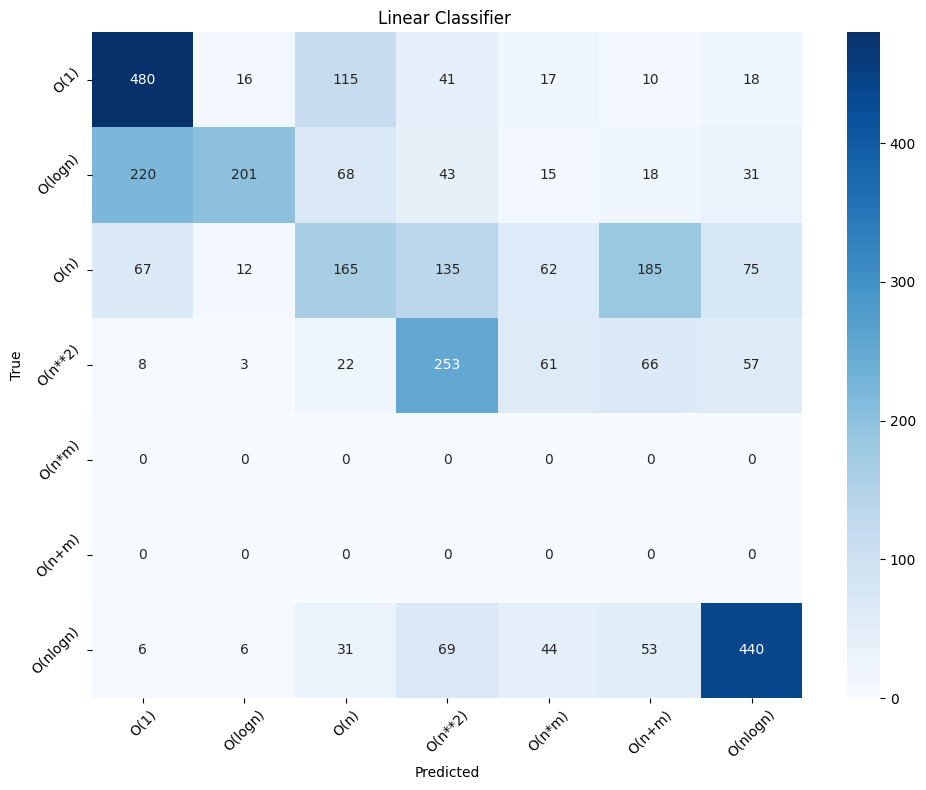

In [ ]:
#Compute confusion_matrix considering only labels present
cm = confusion_matrix(labels, y_pred, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Linear Classifier ")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("\n=== Logistic Regression Classification Report ===")
report = classification_report(
    labels,
    y_pred,
    target_names=class_names,
    zero_division=0
)
print(report)


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

        O(1)       0.61      0.69      0.65       697
     O(logn)       0.84      0.34      0.48       596
        O(n)       0.41      0.24      0.30       701
     O(n**2)       0.47      0.54      0.50       470
      O(n*m)       0.00      0.00      0.00         0
      O(n+m)       0.00      0.00      0.00         0
    O(nlogn)       0.71      0.68      0.69       649

    accuracy                           0.49      3113
   macro avg       0.44      0.35      0.37      3113
weighted avg       0.61      0.49      0.53      3113


### Evaluation of LSTM

In [ ]:
solution_codes = [item['solution_code'] for item in final_dataset_without_tags_linear_LSTM]
complexity =     [item['time_complexity'] for item in final_dataset_without_tags_linear_LSTM]

import numpy as np
N_classes = 7
labels = ["O(1)", "O(n)", "O(n+m)", "O(n**2)", "O(nlogn)", "O(logn)", "O(n*m)"]

one_hot_classes = np.identity(N_classes)
def classes_map(class_string):
  if(class_string not in labels):
    return [0]*N_classes
  return one_hot_classes[labels.index(class_string)]

complexity_one_hot = [classes_map(item) for item in complexity]

test_tf = tf.data.Dataset.from_tensor_slices((solution_codes, complexity_one_hot))
test_dataset = test_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

model_LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy (from_logits=True), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-4))

In [ ]:
y_pred = model_LSTM.predict(test_dataset)
import numpy as np
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


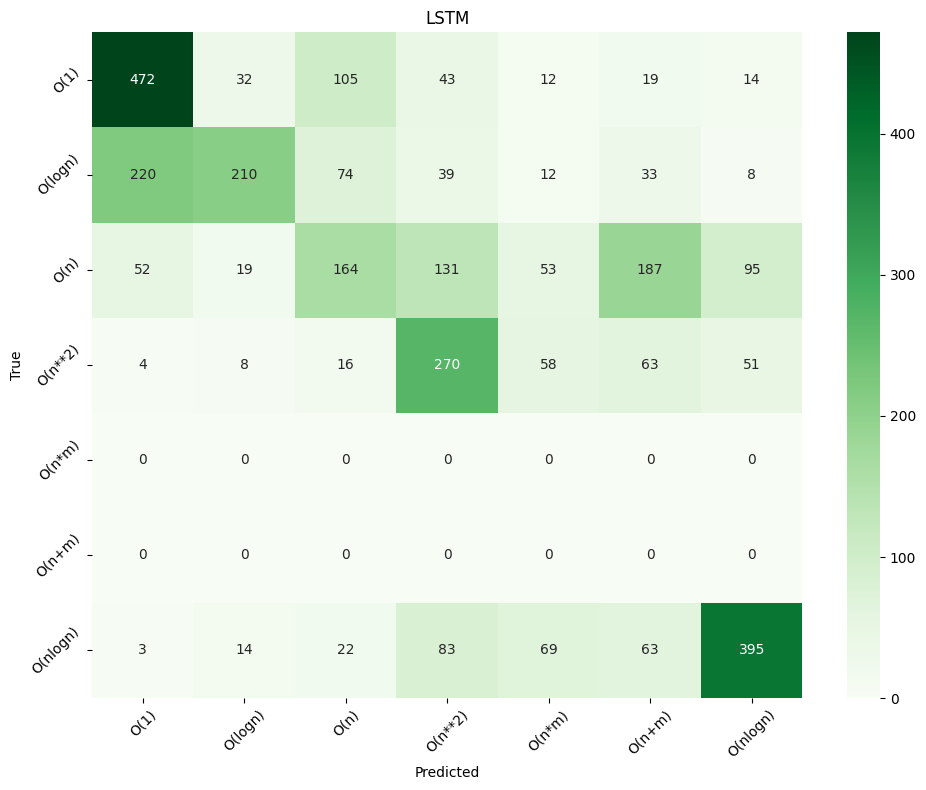

In [ ]:
new_order = ['O(1)', 'O(logn)', 'O(n)', 'O(n**2)', 'O(n*m)', 'O(n+m)', 'O(nlogn)']

labels = [0, 5, 1, 3, 6, 2, 4]

import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=new_order, yticklabels=new_order)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("\n=== LSTM Classification Report ===")
report = classification_report(
    y_true_classes,
    y_pred_classes,
    labels = labels,
    target_names=new_order,
    zero_division=0
)
print(report)


=== LSTM Classification Report ===
              precision    recall  f1-score   support

        O(1)       0.63      0.68      0.65       697
     O(logn)       0.74      0.35      0.48       596
        O(n)       0.43      0.23      0.30       701
     O(n**2)       0.48      0.57      0.52       470
      O(n*m)       0.00      0.00      0.00         0
      O(n+m)       0.00      0.00      0.00         0
    O(nlogn)       0.70      0.61      0.65       649

    accuracy                           0.49      3113
   macro avg       0.43      0.35      0.37      3113
weighted avg       0.60      0.49      0.52      3113


### Evaluation of Custom Transformer

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


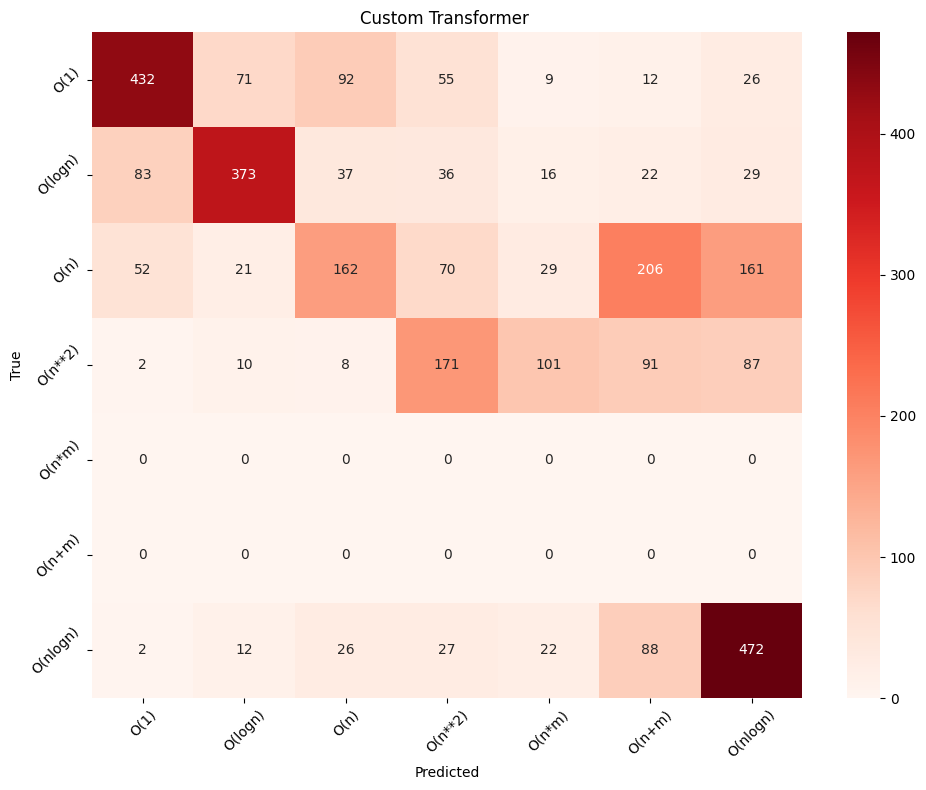


=== Custom Transformer Report ===
              precision    recall  f1-score   support

        O(1)       0.76      0.62      0.68       697
     O(logn)       0.77      0.63      0.69       596
        O(n)       0.50      0.23      0.32       701
     O(n**2)       0.48      0.36      0.41       470
      O(n*m)       0.00      0.00      0.00         0
      O(n+m)       0.00      0.00      0.00         0
    O(nlogn)       0.61      0.73      0.66       649

    accuracy                           0.52      3113
   macro avg       0.44      0.37      0.39      3113
weighted avg       0.63      0.52      0.56      3113


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

from sklearn.metrics import confusion_matrix, classification_report


class_names = [id2label[i] for i in range(len(id2label))]

cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4,5,6])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Custom Transformer ")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== Custom Transformer Report ===")
report = classification_report(
    all_labels, all_preds, target_names=class_names, zero_division=0
)


print(report)



### Evaluation of Fine-Tuned CodeBERT

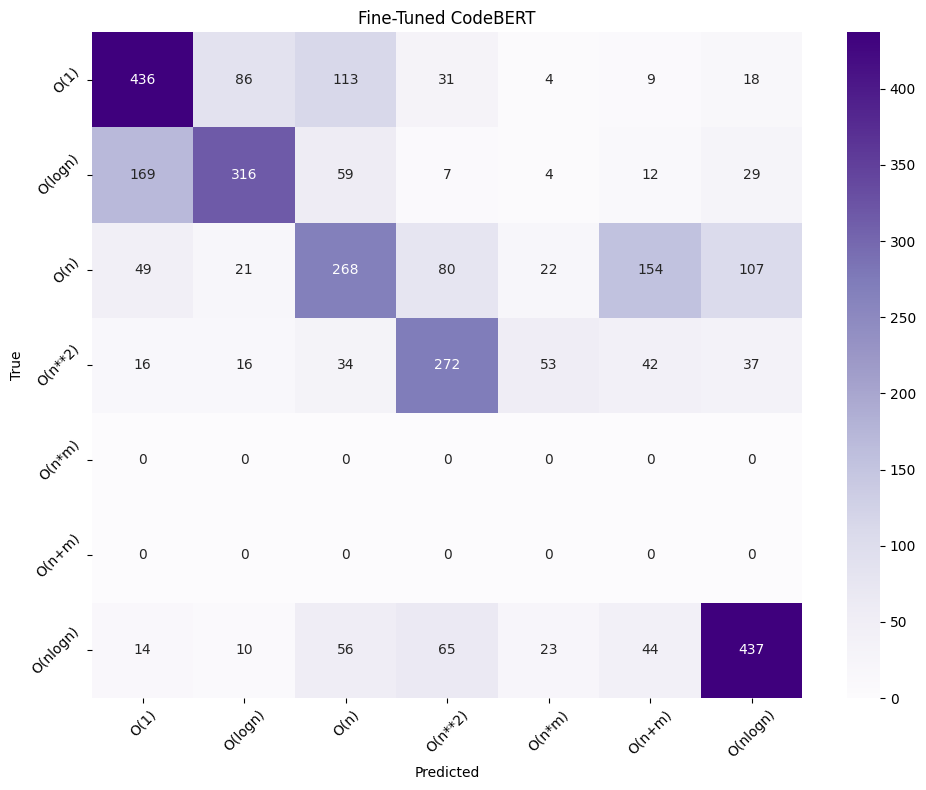


=== Fine-tuned CodeBERT Report ===
              precision    recall  f1-score   support

        O(1)       0.64      0.63      0.63       697
     O(logn)       0.70      0.53      0.60       596
        O(n)       0.51      0.38      0.44       701
     O(n**2)       0.60      0.58      0.59       470
      O(n*m)       0.00      0.00      0.00         0
      O(n+m)       0.00      0.00      0.00         0
    O(nlogn)       0.70      0.67      0.68       649

    accuracy                           0.56      3113
   macro avg       0.45      0.40      0.42      3113
weighted avg       0.63      0.56      0.59      3113


In [ ]:
model_bert.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in train_dataloader_without_tags:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model_bert(input_ids=input_ids, attention_mask=attention_mask).logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

from sklearn.metrics import confusion_matrix, classification_report


class_names = [id2label[i] for i in range(len(id2label))]

cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4,5,6])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Fine-Tuned CodeBERT")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== Fine-tuned CodeBERT Report ===")
report = classification_report(
    all_labels, all_preds, target_names=class_names, zero_division=0
)


print(report)

## Conclusions

 **Model Accuracy Comparison (BigOBench → CodeComplex)**

| Model                    | Accuracy on BigOBench | Accuracy on CodeComplex | Drop |
|--------------------------|------------------------|---------------------------|------|
| Linear Classifier (TF-IDF) | 73%                   | 49%                      | -24% |
| LSTM                     | 71%                   | 49%                      | -22% |
| Custom Transformer       | 82%                   | 52%                      | -30% |
| Fine-tuned CodeBERT      | 90%                   | 56%                      | -34% |

---

**Observations**

Despite the large performance gaps visible on BigOBench, where for example we can see that the transformer-based models clearly outperform the linear classifier and the LSTM, these differences drastically decrease on CodeComplex. This highlights how **BigOBench is a much simpler and biased dataset**, while **CodeComplex provides a more realistic and challenging evaluation**.

This leads to an **incredible but explainable result** as we had imagined during the data analysis phase: the TF-IDF linear classifier ends up performing comparably to much more advanced models like Transformers and LSTMs, in particular for two reasons:
- 1) **Term frequency** may seem like an old and outdated approach at first glance. However, in some cases like this, it may be surprising how a basic approach like this can represent a robust and interesting baseline for a complex task like classifying the time complexity of algorithms.
- 2) In this context, **data play a fundamental role**. Although you can use powerful models with a much higher generalization capacity than others, the performance difference narrows considerably if this power is not supported by sufficient data quality, as we can see in this case where the differences between very different models are reduced in a more realistic dataset.

Furthermore, to highlight the difficulty of CodeComplex, we show this table made by its authors that shows how our models performed comparably (and better) than well-known LLMs. \\
However, in this comparison it must be taken into account that unlike this table which considers all CodeComplex we have considered the acceptable subset for our task, that is 3113 of the 4900 total Python codes, containing only: the 5 classes compatible with our models and tokenizable codes with a maximum of 512 tokens. \\
**Reference**: https://github.com/sybaik1/CodeComplex

**Leaderboard – LLM models on CodeComplex**

| Model             | Accuracy | F1 Score | HC Score |
|------------------|----------|----------|----------|
| **ChatGPT 4.0**   | **56.9** | **56.7** | **88.6** |
| ChatGPT 3.5       | 49.9     | 48.6     | 85.2     |
| Llama3.1-70B      | 44.2     | 43.8     | 81.3     |
| Mistral-12B       | 42.3     | 44.3     | 73.2     |
| Gemma2-9B         | 41.1     | 43.5     | 71.5     |
| Qwen2.5–7B        | 34.2     | 39.9     | 57.8     |
| Qwen2–7B          | 33.6     | 31.9     | 77.1     |
| Gemini Pro        | 34.0     | 31.6     | 80.2     |
| Llama3.1-8B       | 30.0     | 28.4     | 73.8     |
| CodeGemma–7B      | 25.7     | 28.9     | 56.7     |
| Gemma1.1–7B       | 25.7     | 28.7     | 57.3     |
| Llama3.2–3B       | 22.9     | 22.8     | 60.6     |
| Gemma2–27B        | 13.2     | 17.5     | 19.8     |
| Qwen2.5–14B       | 4.0      | 7.2      | 6.6      |
